# Tweede Kamer speeches


Alle Tweede Kamer parlementaire debatten van 1995 t/m juni-2019 zijn in een data set verzameld. Dat is het werk van:

Rauh, Christian; Schwalbach, Jan, 2020, "0_RauhSchwalbach_2020_ParlSpeechV2_ReleaseNote.pdf", The ParlSpeech V2 data set: Full-text corpora of 6.3 million parliamentary speeches in the key legislative chambers of nine representative democracies, https://doi.org/10.7910/DVN/L4OAKN/C2TWCZ, Harvard Dataverse, V1

Voor meer informatie [zie deze site](https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/L4OAKN).

The original data on the webiste was an R rds file, I imported that in R and saved it as csv, then zipped it. But the zip file was too large to put on GitHub so I used the command line tool split to create 24 Mb chuncks. CorpusTweedeKamera .... CorpusTweedekamerl. You need to put those chuncks to one zip again.

## Analyze mogelijkheden

* Metadata anlyse
* Topic modeling
* Word2Vec
* CLassificatie naar partij
* en veel meer.....



In [1]:
import pandas as pd
import gensim
import plotly.express as px
import seaborn as sns

In [6]:
## put data chuncks in one zip file
!cat data/CorpusTweedeKamer* > CorpusTweedeKamer.zip

In [2]:
%%time
tweede_kamer = pd.read_csv("CorpusTweedeKamer.zip")

CPU times: user 12.3 s, sys: 724 ms, total: 13 s
Wall time: 13.1 s


In [3]:
tweede_kamer = (
    tweede_kamer
    .assign(datum = pd.to_datetime(tweede_kamer.date))
)

In [4]:
tweede_kamer.sample(10)

,date,agenda,speechnumber,speaker,party,party.facts.id,chair,terms,text,parliament,iso3country,datum
773162,2013-05-29,NaN,289,Timmermans,PvdA,1234.0,False,204,De heer Madlener spreekt over recht. Ik moet d...,NL-TweedeKamer,NLD,2013-05-29
989524,2017-05-18,NaN,222,Van Dam,CDA,1157.0,False,96,Die 20% is het maximum voor de derde tranche d...,NL-TweedeKamer,NLD,2017-05-18
384154,2005-02-08,NaN,49,VOORZITTER,other,NaN,True,27,"Deze motie is voorgesteld door de leden Slob, ...",NL-TweedeKamer,NLD,2005-02-08
60369,1996-06-27,NaN,237,Reitsma,CDA,1157.0,False,91,Dat betekent dat de gang van de minister naar ...,NL-TweedeKamer,NLD,1996-06-27
376900,2004-11-18,NaN,542,Wijn,CDA,1157.0,False,25,"Ik heb de vragen zelf nog niet gezien, maar ik...",NL-TweedeKamer,NLD,2004-11-18
1101362,2018-12-20,NaN,363,De heer Voordewind,CU,1459.0,False,44,Heel kort. Maar er gaan diensten die kant op. ...,NL-TweedeKamer,NLD,2018-12-20
953625,2016-09-29,NaN,625,De heer Van Vliet,other,NaN,False,49,Het gaat over die stemmingsuitslag. Ik was voo...,NL-TweedeKamer,NLD,2016-09-29
917724,2016-02-18,NaN,82,Mevrouw Vermeij,PvdA,1234.0,False,15,Mijn stelling was een andere dan de verdraaiin...,NL-TweedeKamer,NLD,2016-02-18
484277,2007-11-13,NaN,222,Van der Staaij,SGP,1178.0,False,37,Om de flexibiliteit van de pot niet al te zeer...,NL-TweedeKamer,NLD,2007-11-13
371348,2004-10-14,NaN,604,Halsema,GL,1537.0,False,644,Voorzitter. Alle sprekers hebben tot dusver ge...,NL-TweedeKamer,NLD,2004-10-14


## Metadata analyse
Non NLP Analysis on the parlement speech data

In [6]:
partijen = (
    tweede_kamer.party
    .value_counts()
    .to_frame()
    .reset_index()
)

In [7]:
fig = px.bar(partijen,x= "index", y = "party", width = 1000, title = "aantal speeches per partij")
fig

In [21]:
sprekers =(
    tweede_kamer
    .speaker
    .value_counts()
    .to_frame()
    .reset_index()
)

In [26]:
sprekers.head(10)

,index,speaker
0,VOORZITTER,71577
1,De voorzitter,63670
2,voorzitter,41256
3,Rutte,9779
4,Halsema,8794
5,Pechtold,8172
6,Van der Vlies,7946
7,Dittrich,7455
8,Balkenende,7437
9,Donner,7356


In [25]:
fig = px.bar(sprekers, x= "index", y = "speaker", width = 2000)
fig

In [6]:
perdag =(
    tweede_kamer
    .datum
    .value_counts()
    .to_frame()
    .reset_index()
)

In [10]:
perdag = perdag.sort_values("index")

In [13]:
perdag

,index,datum
1351,1994-12-20,408
1749,1994-12-21,317
2443,1995-01-24,47
1781,1995-01-25,307
2143,1995-01-26,208
...,...,...
64,2019-06-26,974
428,2019-06-27,679
1343,2019-07-02,410
13,2019-07-03,1187


In [12]:
px.line(perdag, x = "index", y ="datum", width= 1500)

In [14]:
tweede_kamer.query("terms < 10")

,date,agenda,speechnumber,speaker,party,party.facts.id,chair,terms,text,parliament,iso3country,datum
96,1994-12-20,NaN,97,Van Middelkoop,GPV,1602.0,False,9,Volhouden!,NL-TweedeKamer,NLD,1994-12-20
464,1994-12-21,NaN,57,Jorritsma-van Oosten,D66,45.0,False,9,Ja.,NL-TweedeKamer,NLD,1994-12-21
465,1994-12-21,NaN,58,Lansink,CDA,1157.0,False,9,Waarom?,NL-TweedeKamer,NLD,1994-12-21
532,1994-12-21,NaN,125,Van Gelder,PvdA,1234.0,False,9,Voorzitter!...,NL-TweedeKamer,NLD,1994-12-21
537,1994-12-21,NaN,130,VOORZITTER,other,NaN,True,6,Zeker.,NL-TweedeKamer,NLD,1994-12-21
...,...,...,...,...,...,...,...,...,...,...,...,...
1143351,2019-07-04,NaN,955,De heer Hiddema,FvD,5855.0,False,5,Dat was mijn maritieme bijdrage.,NL-TweedeKamer,NLD,2019-07-04
1143353,2019-07-04,NaN,957,De voorzitter,,NaN,True,6,Het woord is aan de staatssecretaris.,NL-TweedeKamer,NLD,2019-07-04
1143357,2019-07-04,NaN,961,De voorzitter,,NaN,True,7,Eén vraag van de heer Van Ojik.,NL-TweedeKamer,NLD,2019-07-04
1143360,2019-07-04,NaN,964,De voorzitter,,NaN,True,5,"Mevrouw Van Toorenburg knikt ""ja"".",NL-TweedeKamer,NLD,2019-07-04


In [15]:
tweede_kamer.shape

(1143366, 12)

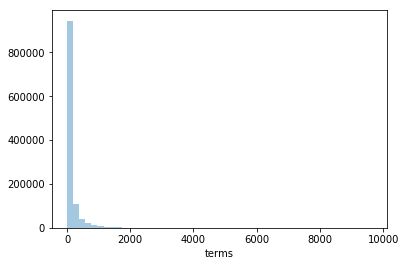

In [19]:
sns.distplot(tweede_kamer.terms,kde=False)

In [18]:
tweede_kamer.terms.describe()

count    1.143366e+06
mean     1.415003e+02
std      2.320758e+02
min      1.000000e+00
25%      3.200000e+01
50%      7.300000e+01
75%      1.440000e+02
max      9.627000e+03
Name: terms, dtype: float64